CONTROL wls = 0.0031525891432063933
CD1 wls = 0.003953873398351445
CD2 wls = 0.0038836383505445994


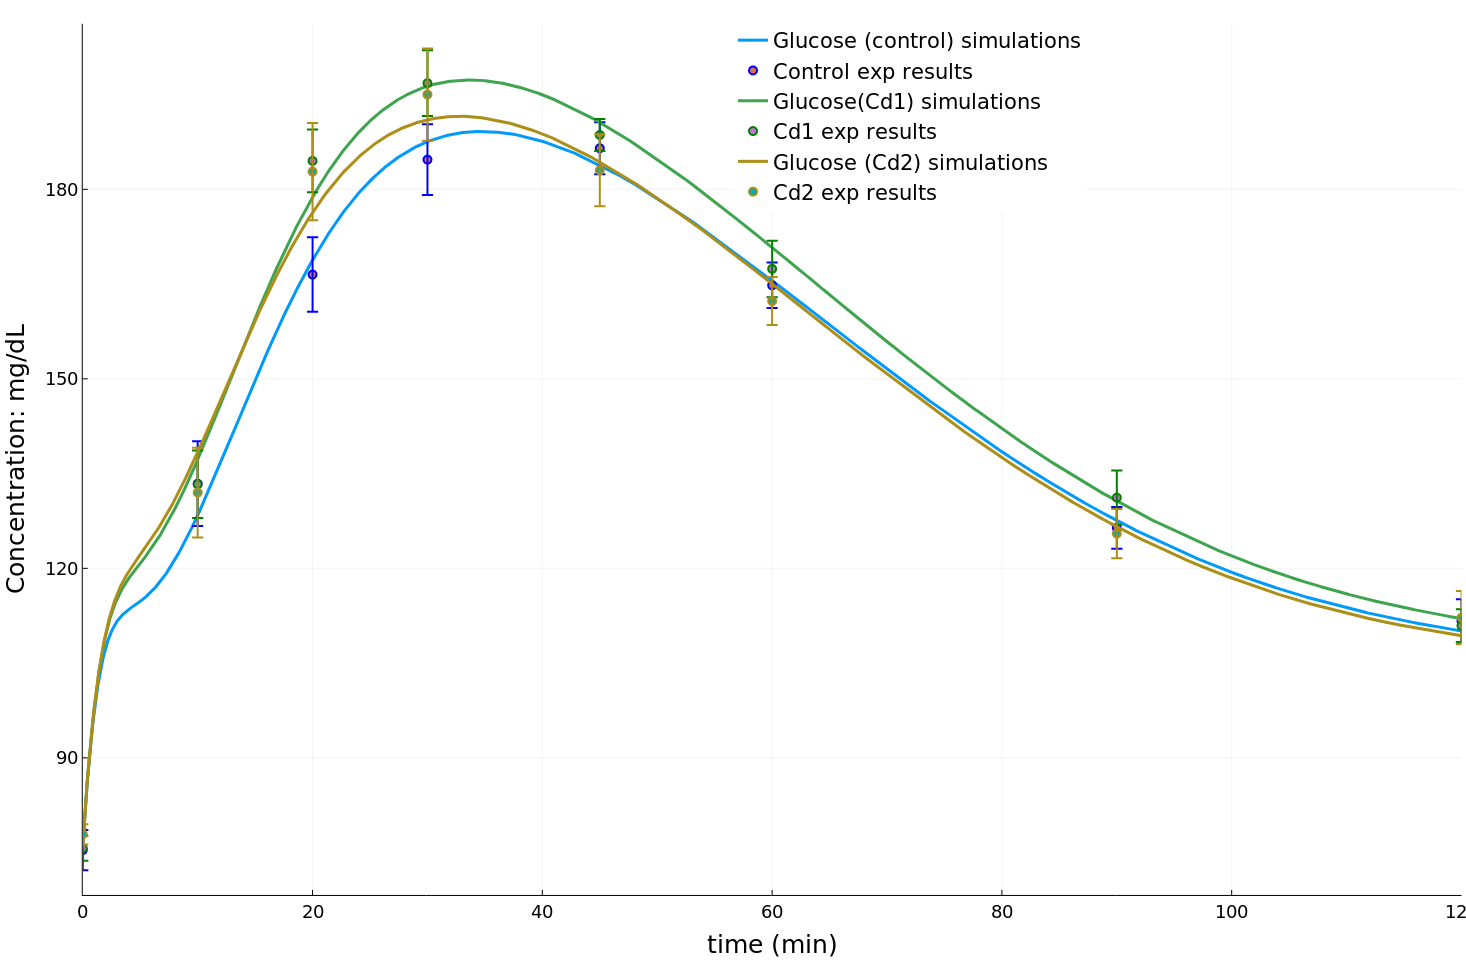

In [2]:
# NEEDED MODULES -- This can take time at the first launch
# Code main be needed to run twice to plot correctly (shift-enter)
using DifferentialEquations
using Plots
using LaTeXStrings
# Load the backend (engine) for plotting based on javascript
plotlyjs()

function weighted_leastsquare(O,R,E)
    denom  = sum(O.^2)
    weights = 1. / (E.^2)
    return sqrt(sum(weights.*(O-R).^2)/denom)
end

function leastsquare(O,R)
    denom  = sum(O.^2)
    return sqrt(sum((O-R).^2)/denom)
end

# Saturation function to positive values 
# (concentrations are positive function)
# This is just used as a safety for the parameter search phase
@inline function sat(x)
    if x < 0.0
        return 0.0
    else
        x
    end
end

# Gaussian model of plasma Glucose appearance rate
function GlcGauss(t)
    σ = 35.0 # width
    μ = 30.0 # peak time
    dose = 4040 # total glucose dose (area under curve)
    return dose*1/(σ*sqrt(2*pi))*exp((-(t-μ)^2/(2*σ^2)))
end

# Parametric ODEs of te Glucose response model
# t : time
# u : variables
# p : parameters
# Here I call the guassian model of glucose input GlcGauss(t)
# And I saturate the variables to the positive cone
function f_param!(du,u,p,t)
 du[1] = -p[1]*(sat(u[1])-p[2])- p[10]*sat(u[2])*sat(u[1])+GlcGauss(t)
 du[2] = -p[3]*sat(u[2])+p[4]*(sat(u[3])-p[5])
 du[3] = -p[6]*sat(u[3])+p[7]*(sat(u[1])-p[8])*t + p[9]*u[4]
 du[4] = -p[9]*u[4]           
end   
  

# Initial conditions at 26j
u0 = [76.0,0.0,34.0,5950]
tspan = (0.0,120.0)


# #  A Parameter set from the MINMOD model as a reference
# #       p1  Gb    p2    p3     Ib  n   γ    h     |added parameters => |     p4    r
# p0 = [0.01,100.0,0.01,0.00001,8.0,0.1,0.01,100.0,                           0.07,1.0]

    

# Fitted parameter set to the control group at 26 Days ===> err: 0.00315
#         p1    Gb    p2     p3     Ib     n      γ      h     p4     r
 p0 = [0.01, 100.0, 0.61, 0.0245, 05.0, 09.44, 0.0110, 79.0, 0.0215,  1.0] 
###################################################
## Simulation of the Control experiment at 26Days    
prob_param = ODEProblem(f_param!,u0,tspan,p0)  
sctrl = solve(prob_param, alg_hints = [:stiff])
## Experimental results    
texp = [0,10,20,30,45,60,90,120]
glcexp = [75.4,133.4,166.5,184.7,186.5,164.8,126.4,111.7]
uppererror = [3.2,6.7,5.9,5.6,4.1,3.6,3.3,3.4]
lowererror = [3.2,6.7,5.9,5.6,4.1,3.6,3.3,3.4]
errs = [lowererror;uppererror]
res_tot = [sctrl(ti) for ti in texp]
res = [ri[1] for ri in res_tot]
## Computation of the weighted least square error and least square
wls_err_Ctrl = weighted_leastsquare(glcexp,res,uppererror)
print("CONTROL wls = ", wls_err_Ctrl, "\n")
ls_err_Ctrl = leastsquare(glcexp,res)    
## Generation of the figure and first plots 
plot(sctrl,vars=[(0,1)],label="Glucose (control) simulations")
scatter!(texp,glcexp,yerr = errs,marker = stroke(2, :blue),
       xlabel="time (min)", ylabel= "Concentration: mg/dL",
    label="Control exp results", legend=:top, markerstrokecolor = :auto)

    
    
# Parameters sets for the different hypothesis for the group CD1 at 26 Days
########################################################################    
# Control parameter set  ===>   err: 0.00972
#        p1    Gb     p2     p3    Ib     n       γ      h     p4      r
# p0 = [0.01, 100.0, 0.61, 0.0245, 05.0, 09.44, 0.0110, 79.0, 0.0215,  1.0] 
# hypothese 1.1: sensibility to interstitial insuline (r) ===> err : 0.00411
# p0 = [0.01, 100.0, 0.61, 0.0245, 05.0, 09.44, 0.0110, 79.0, 0.0215,  0.91] 
# hypothese 1.2: disponibility of insuline for X(t) (p3) ==> err: 0.004105
# p0 = [0.01, 100.0, 0.61, 0.0224, 05.0, 09.44, 0.0110, 79.0, 0.0215,  1.0] 
# hypothese 2: degradation  insuline (n) ==> err : 0.00395
 p0 = [0.01, 100.0, 0.61, 0.0245, 05.0, 9.93, 0.0110, 79.0, 0.0215,  1.0] 
# hypothese 3: interstitial insuline degradation (p2) ==> err : 0.00398
# p0 = [0.01, 100.0, 0.67, 0.0245, 05.0, 09.44, 0.0110, 79.0, 0.0215,  1.0] 
# hypothesis 4: γ (Insuline production acceleration) decreased  ==> err =  0.00762
# p0 = [0.01, 100.0, 0.61, 0.0245, 05.0, 09.44, 0.0100, 79.0, 0.0215,  1.0] 
# hypothesis 5:  change p4 (stored insuline release rate)  ==> err = 0.00638        
# p0 = [0.01, 100.0, 0.61, 0.0245, 05.0, 09.44, 0.0110, 79.0, 0.0200,  1.0] 
# hypothese 6: reponse Glucose threshold (h)  ==> err:  0.00819
# p0 = [0.01, 100.0, 0.61, 0.0245, 05.0, 09.44, 0.0110, 85.0, 0.0215,  1.0] 
########################################################################
# Simulation CD1 26 days    
prob_param = ODEProblem(f_param!,u0,tspan,p0)
scd1 = solve(prob_param, alg_hints = [:stiff])
# Experimental results    
glcexpCd1 = [75.7,133.3,184.5,196.8,188.6,167.4,131.2,110.9]
uppererror = [1.97,5.34,4.96,5.21,2.52,4.47,4.30,2.64]
lowererror = [1.97,5.34,4.96,5.21,2.52,4.47,4.30,2.64]
errs = [lowererror;uppererror]
res_tot = [scd1(ti) for ti in texp]
res = [ri[1] for ri in res_tot]
# Error computation    
wls_err_Cd1 = weighted_leastsquare(glcexpCd1,res,uppererror)
print("CD1 wls = ", wls_err_Cd1, "\n")
ls_err_Cd1 = leastsquare(glcexpCd1,res)
# Plotting    
plot!(scd1,vars=[(0,1)],label="Glucose(Cd1) simulations")
scatter!(texp,glcexpCd1,yerr = errs,marker = stroke(2, :green),
      xlabel="time (min)", ylabel= "Concentration: mg/dL",
      label="Cd1 exp results", legend=:top, markerstrokecolor = :auto)

    
# Parameters sets for the different hypothesis for the group CD2 at 26 Days
########################################################################    
# Control parameter set  ===>  err: 0.00600
#        p1    Gb     p2     p3    Ib     n       γ      h     p4      r
# p0 = [0.01, 100.0, 0.61, 0.0245, 05.0, 09.44, 0.0110, 79.0, 0.0215,  1.0]
# hypothese 1.1: sensibility to interstitial insuline (r) ==> err: 0.00444
# p0 = [0.01, 100.0, 0.61, 0.0245, 05.0, 09.44, 0.0110, 79.0, 0.0215,  0.93]
# hypothese 1.2: disponibility of insuline for X(t) (p3) ==> err : 0.00435
# p0 = [0.01, 100.0, 0.61, 0.0230, 05.0, 09.44, 0.0110, 79.0, 0.0215,  1.0]
# hypothese 2: degradation  insuline (n) ==> err : 0.00442
# p0 = [0.01, 100.0, 0.61, 0.0245, 05.0, 09.75, 0.0110, 79.0, 0.0215,  1.0]
# hypothese 3: interstitial insuline degradation (p2) ==> err: 0.00434
# p0 = [0.01, 100.0, 0.65, 0.0245, 05.0, 09.44, 0.0110, 79.0, 0.0215,  1.0]
# hypothesis 4: γ (Insuline production acceleration) decreased  ==> err =  0.00584
# p0 = [0.01, 100.0, 0.61, 0.0245, 05.0, 09.44, 0.0107, 79.0, 0.0215,  1.0] 
# hypothesis 5:  change p4 (stored insuline release rate)  ==> err = 0.00388
 p0 = [0.01, 100.0, 0.61, 0.0245, 05.0, 09.44, 0.0110, 79.0, 0.0201,  1.0] 
# hypothese 6: reponse Glucose threshold (h)  ==> err: 0.0058
# p0 = [0.01, 100.0, 0.61, 0.0245, 05.0, 09.44, 0.0110, 81.0, 0.0215,  1.0] 
##########################################################################
# Simulation Group CD2 26 days    
prob_param = ODEProblem(f_param!,u0,tspan,p0)
scd2 = solve(prob_param, alg_hints = [:stiff])
# Experimental results    
glcexpCd2 = [77.9,132,182.8,195,183,162.3,125.5,112.2]
uppererror = [1.6,7.1,7.7,7.3,5.7,3.8,3.9,4.2]
lowererror = [1.6,7.1,7.7,7.3,5.7,3.8,3.9,4.2]
errs = [lowererror;uppererror]
res_tot = [scd2(ti) for ti in texp]
res = [ri[1] for ri in res_tot]
# Error Computation    
wls_err_Cd2 = weighted_leastsquare(glcexpCd2,res,uppererror)
print("CD2 wls = ", wls_err_Cd2, "\n")
ls_err_Cd2 = leastsquare(glcexpCd2,res)
# Plotting    
plot!(scd2,vars=[(0,1)],label="Glucose (Cd2) simulations")
cur_colors = get_color_palette(:auto, plot_color(:white), 17)
scatter!(texp,glcexpCd2,yerr = errs,marker = stroke(2, cur_colors[5]),
       xlabel="time (min)", ylabel= "Concentration: mg/dL",
       label="Cd2 exp results", legend=:top, markerstrokecolor = :auto)
    
# Additionnal plot options    
plot!(size=(1280,960),legendfontsize=15, xtickfont=font(13), ytickfont=font(13), guidefont=font(18))
# savefig("OGTT_26.pdf")